## Creating a tensor 
We can't do any differentiation if we don't have any numbers to differentiate, so first we need to create an object that we can apply operations to. We'll want to include some special behaviour for these numbers so we can't just use a python builtin. Instead, we'll create an object which we'll call a `Tensor`:

In [16]:
class Tensor:
    """
    A float
    """
    def __init__(self, value: float):
        self.value = value

Next we'll need some operations we want to perform. How about (scalar) addition, multiplication and powers:

In [41]:
def _add(a: Tensor, b: Tensor):
    """
    Add two tensors
    """
    return Tensor(a.value + b.value)

def _mul(a: Tensor, b: Tensor):
    """
    Multiply two tensors
    """
    return Tensor(a.value * b.value)

We can use our operations as follows:

In [42]:
a = Tensor(3)
b = Tensor(4)

_mul(a, b).value

12

To make our `Tensor`s a bit more usable, we can define some special methods

In [56]:
class Tensor:
    """
    A float
    """
    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        return f"Tensor({self.value.__repr__()})"

    def __add__(self, other: "Tensor"):
        assert isinstance(other, Tensor), "Can only add a Tensor to a Tensor"
        return _add(self, other)

    def __mul__(self, other: "Tensor"):
        assert isinstance(other, Tensor), "Can only multiply a Tensor with a Tensor"
        return _mul(self, other)

    def __eq__(self, other: "Tensor"):
        if not isinstance(other, Tensor):
            return False
        return self.value == other.value

THREE = Tensor(3)
FOUR = Tensor(4)

assert THREE + FOUR == Tensor(7)
assert THREE * FOUR == Tensor(12)

assert (THREE * FOUR) + THREE == Tensor(15)

Under the hood, we can now see that when we apply some operations to a tensor, for example:

In [36]:
THREE * FOUR + THREE

Tensor(15)

What it actually does is first parse the statement into some nested functions

In [35]:
_add(_mul(THREE, FOUR), THREE)

Tensor(15)

This is important because what we'll end up doing is figuring out a way to differentiate nested functions and by defining the special functions in our tensor class, we'll be able to make our library a lot more usable without much effort.

## Scalar derivatives
Before we start doing full matrix derivatives, lets start by figuring out the derivatives of scalars. The simplest of these is the derivative of a tensor with respect to (wrt) itself:
$$\frac{dx}{dx} = 1$$

A more interesting case is the derivative of two tensors added together (note we are using partial derivatives because our function has multiple inputs):
$$f(x, y) = x + y$$
$$\frac{\partial f}{\partial x} = 1$$
$$\frac{\partial f}{\partial y} = 1$$

We can do a similar thing for multiplication

|$f(x, y)$|$\frac{\partial f}{\partial x}$|$\frac{\partial f}{\partial y}$|
|-|-|-|
|$x + y$|$1$|$1$|
|$x \times y$|$y$|$x$|

This means that if we have a variable produced by one of our functions, we can differentiate it wrt one of its inputs. If we make a `Tensor` from an operation, we need to store the derivative function in the `Tensor`.

We'll add three new attributes to our `Tensor`: `args`, `back_fns` and `grad`. If the tensor is the output of an operation, then `args` will store the arguments to the operation, `back_fns` will store some functions that calculate the derivative of the tensor wrt the operation inputs and `grad` will store the dervative once we've actually calculated it.


In [91]:
# TODO replace partials with lambdas
f = partial(_mul, 4)
f = lambda x: _mul(4, x)

```python
class Tensor:
    """
    A float that can be differentiated
    """
    # If the tensor was made by an operation, the operation arguments
    # are stored in args
    args: Tuple[Tensor]
    # If this tensor was made by an operation, back_fns 
    # stores the functions that calculate the derivative of this tensor
    # wrt the operation inputs
    back_fns: tuple[callable] | None = None
    # The derivative (once we've calculated it). This is None if the derivative
    # has not been computed yet
    grad: "Tensor" | None = None
    
    
    def __init__(self, value: float):
        self.value = value

    # ...
```

For example, if we have 

In [92]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)

Then `output.args` and `output.back_fns` should be equal to will be set to 

In [93]:
output.args = (Tensor(3), Tensor(4))
output.back_fns = (
    lambda x: _mul(x, b), # derivative of output wrt a is b
    lambda x: _mul(x, a), # derivative of output wrt b is a
)

Once we have actually computed the derivatives, then the derivative of `output` wrt `a` will be stored in `a.grad` and should be equal to `b` (which is 4 in this case). 

We know that we've done everything right once these tests pass (after computing the derivatives):

In [ ]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)
# TODO: differentiate here

assert output.args == (a, b)
assert output.back_fns == (lambda x: _mul(x, b), lambda x: _mul(x, a))
assert a.grad == b
assert b.grad == a

We're now able to modify our original operations to store the derivatives correctly

In [135]:
def _add(a: Tensor, b: Tensor):
    """
    Add two tensors
    """
    result = Tensor(a.value + b.value)
    result.back_fns = (
        lambda x: _mul(Tensor(1), x), # derivative wrt a
        lambda x: _mul(Tensor(1), x)  # derivative wrt b
    )
    result.args = (a, b)
    return result

def _mul(a: Tensor, b: Tensor):
    """
    Multiply two tensors
    """
    result = Tensor(a.value * b.value)
    result.back_fns = (
        lambda x: _mul(b, x),  # derivative wrt a
        lambda x: _mul(a, x)  # derivative wrt b
    )
    result.args = (a, b)
    return result

We are not actually executing the derivatives here, just defining the functions to calculate them.

We can now add a function to our `Tensor` that will actually calculate the derivatives for each of the function arguments. Pytorch calls this `backward` so we'll do the same

In [136]:
class Tensor:
    """
    A float that can be differentiated
    """
    # If the tensor was made by an operation, the operation arguments
    # are stored in args
    args: tuple[Tensor]
    # If this tensor was made by an operation, back_fns 
    # stores the functions that calculate the derivative of this tensor
    # wrt the operation inputs
    back_fns: tuple[callable] | None = None
    # The derivative (once we've calculated it). This is None if the derivative
    # has not been computed yet
    grad: Tensor | None = None
    
    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        return f"Tensor({self.value.__repr__()})"

    def __add__(self, other: "Tensor"):
        assert isinstance(other, Tensor), "Can only add a Tensor to a Tensor"
        return _add(self, other)

    def __mul__(self, other: "Tensor"):
        assert isinstance(other, Tensor), "Can only multiply a Tensor with a Tensor"
        return _mul(self, other)

    def __eq__(self, other: "Tensor"):
        if not isinstance(other, Tensor):
            return False
        return self.value == other.value

    def backward(self):
        if self.args is None or self.back_fns is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )
        # Store the derivative of this tensor wrt to each of its arguments
        # in the arguments
        for arg, back_fn in zip(self.args, self.back_fns):
            arg.grad = back_fn(Tensor(1))

We could have stored the derivatives for this tensor wrt each of its inputs separately but it turns out to be a lot neater (and helpful for a later algorithm) to store the derivatives wrt function arguments with the function arguments themselves.

We calculated the derivatives by passing $1$ into each function (e.g. $1\times y = y$). This seems weird now but will make more sense when we start working with matrices.

We can now run our tests and see if it works

In [144]:
def lambdas_equal(left_fn, right_fn):
    """
    We cant compare lambda functions directly
    so we'll put some numbers into both and make
    sure that we get the same output
    """
    for val in [0, 1, -12, 4,2, 1e32]:
        val = Tensor(val)
        if left_fn(val) != right_fn(val):
            return False
    return True

In [138]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)
output.backward()


assert output.args == (a, b)
assert lambdas_equal(
    output.back_fns[0], 
    lambda x: _mul(b, x)
)
assert lambdas_equal(
    output.back_fns[1], 
    lambda x: _mul(x, a)
)
assert a.grad == b
assert b.grad == a

TODO: change back_fn to back_fns in the code

So far so good, lets try combining tensors.

In [143]:
a = Tensor(3)
b = Tensor(4)

output_1 = _mul(a, b)
output_2 = _add(a, output_1)

output_2.backward()

# d(output_2)/da = 1 * b = b
assert b.grad == a, b.grad

AssertionError: None

Something has gone wrong. We should have got `a` as the derivative for `b` but we got `None` instead. Looking through the `.backward()` function, we can see that we can only handle single functions. To get this example working, we'll need to to calculate derivatives through multiple functions.

## Chaining Functions Together

To calculate derivates of nested functions, we can use another rule from calculus: The Chain Rule.

For a variable $z$ generated by nested functions $f$ and $g$ such that
$$z = f(g(x))$$

Then the derivative of $z$ wrt $x$ is:
$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x}$$

Here, $u$ is a kind of dummy variable.  $\frac{\partial f(u)}{\partial u}$ means the derivative of $f$ wrt its input.

For example, if 

$$f(x) = g(x)^2$$
Then we can define $u=g(x)$ and rewrite $f$ as 
$$f(u) = u^2$$
In this case, this would make
$$\frac{\partial f(u)}{\partial u} = 2u = 2 g(x)$$

### Multiple Variables
The chain rule works as you might expect for functions of multiple variables:

For
$$z = f(g(x, y), w)$$

$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x}$$
$$\frac{\partial z}{\partial y} = \frac{\partial f(u)}{\partial u} \frac{\partial g(y)}{\partial y}$$
$$\frac{\partial z}{\partial w} = \frac{\partial f(w)}{\partial w}$$

If we have different functions that take the same inputs

$$z = f(g(x), h(x))$$

We get
$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u}\frac{\partial g(x)}{\partial x} + \frac{\partial f(u)}{\partial u}\frac{\partial g(x)}{\partial x} = \frac{\partial f(u)}{\partial u}\left (\frac{\partial g(x)}{\partial x} + \frac{\partial h(x)}{\partial x}\right )$$

### More than 2 functions
If we chain 3 functions together, we get:

$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(u)}{\partial u}\frac{\partial h(x)}{\partial x}$$

And this generalises to any amount of nesting

If
$$z = f_1(f_2(....f_{n-1}(f_n(x))...))$$
Then
$$\frac{\partial z}{\partial x} = \left ( \prod_i^{n-1} \frac{\partial f_i(u)}{\partial u} \right ) \frac{\partial f_n(x)}{\partial x}$$

### A picture is worth a thousand equations
As you probably noticed, the maths is starting to get quite dense. When we start working with neural networks, we can easily get 100s or 1000s of functions deep so, to get a handle on things, we'll need a different strategy. Helpfully, there is one: Diagrammatic formulae.

We can start with some rules:

1. Values are represented with circles. If a value has a name, we put that name in the circle. Otherwise we leave it blank

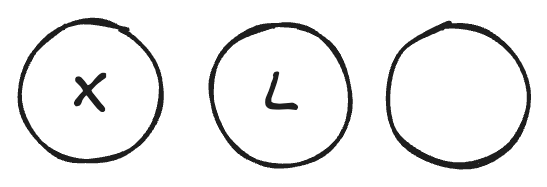</br>
*3 values*

2. Functions are represented by squares

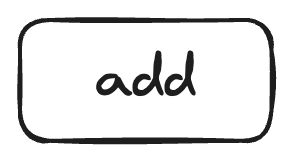</br>
*The add function*

3. If a variable is passed into a function, we draw an arrow from the variable to the function

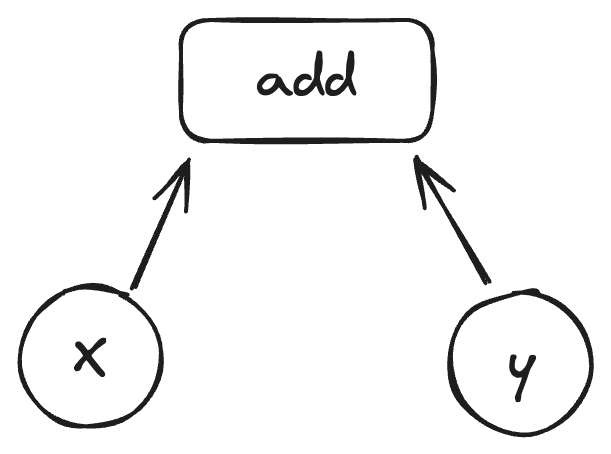</br>
*A diagram of the formula $x+y$*

4. If a variable is produced by a function, we draw an arrow from the function to the variable

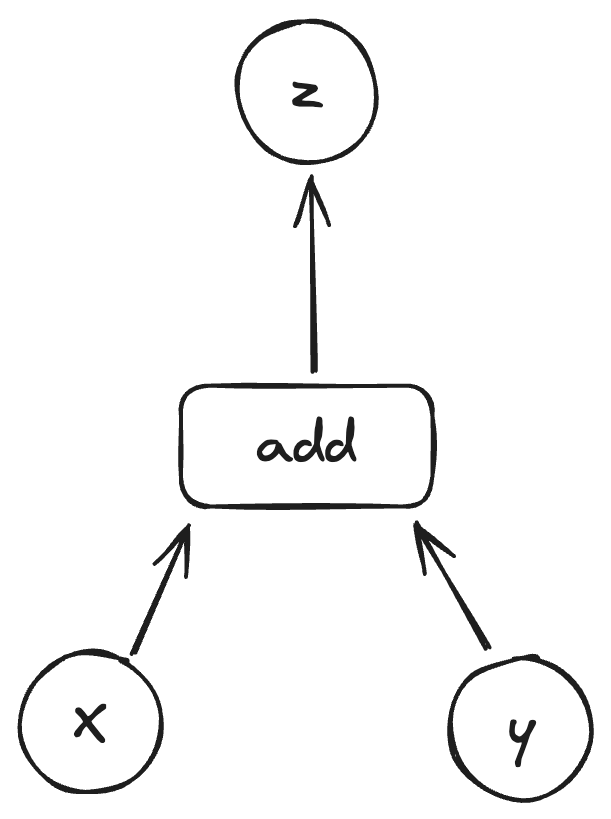</br>
*A diagram of $z = x + y$*

And thats it! All of the equations we'll be working with can be represented graphically using these 4 rules. 

As an example, let's draw the diagram for the following function
$$L = (y - (mx + c))(y - (mx + c))$$

We can start by drawing $mx +c$

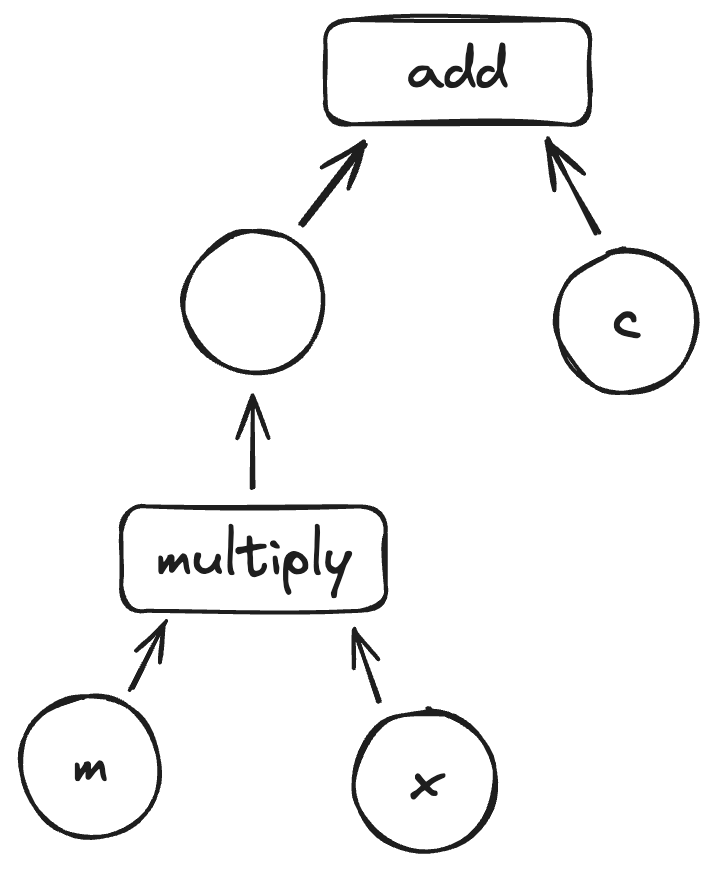

Then $(y - (mx + c))$

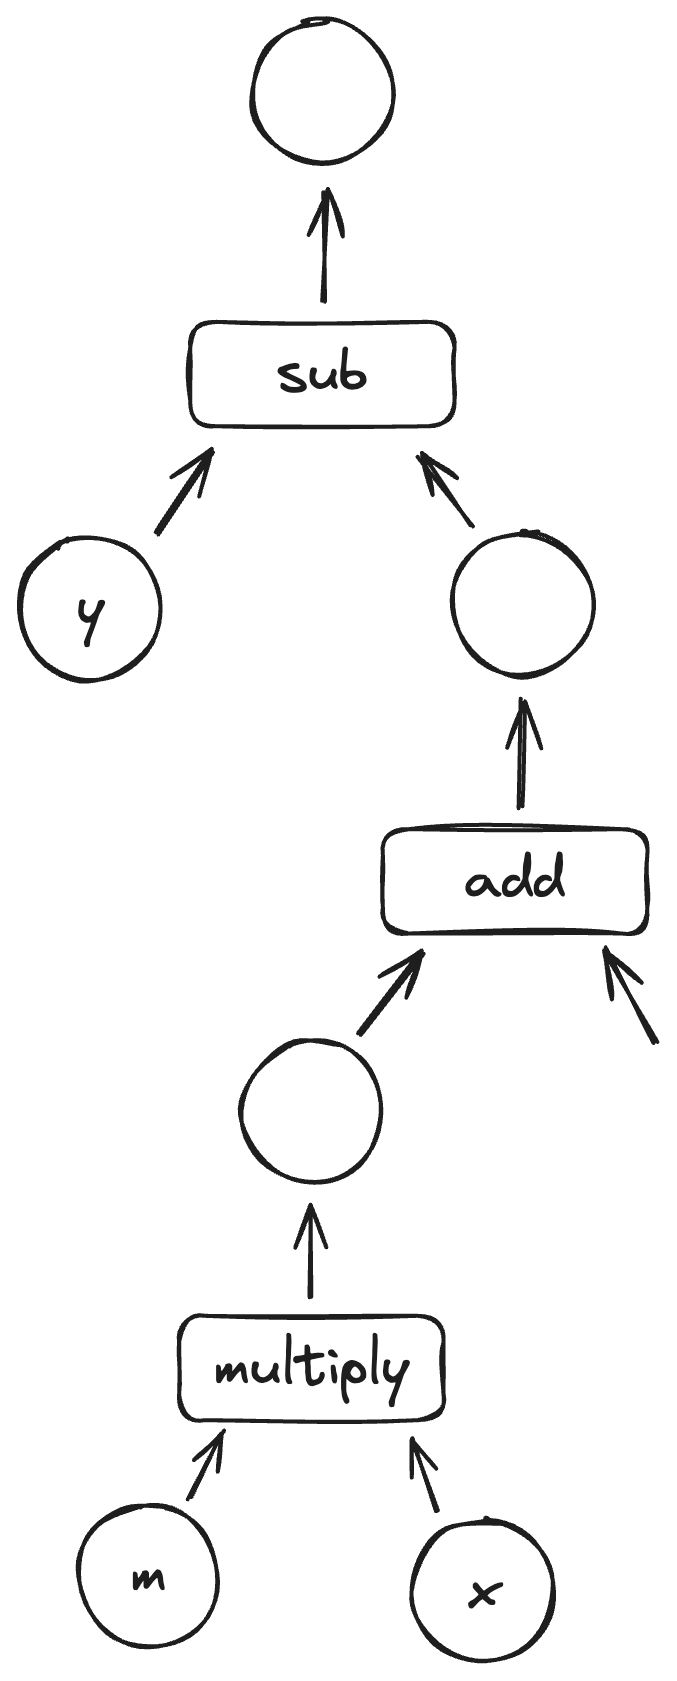

And finally the entire formula

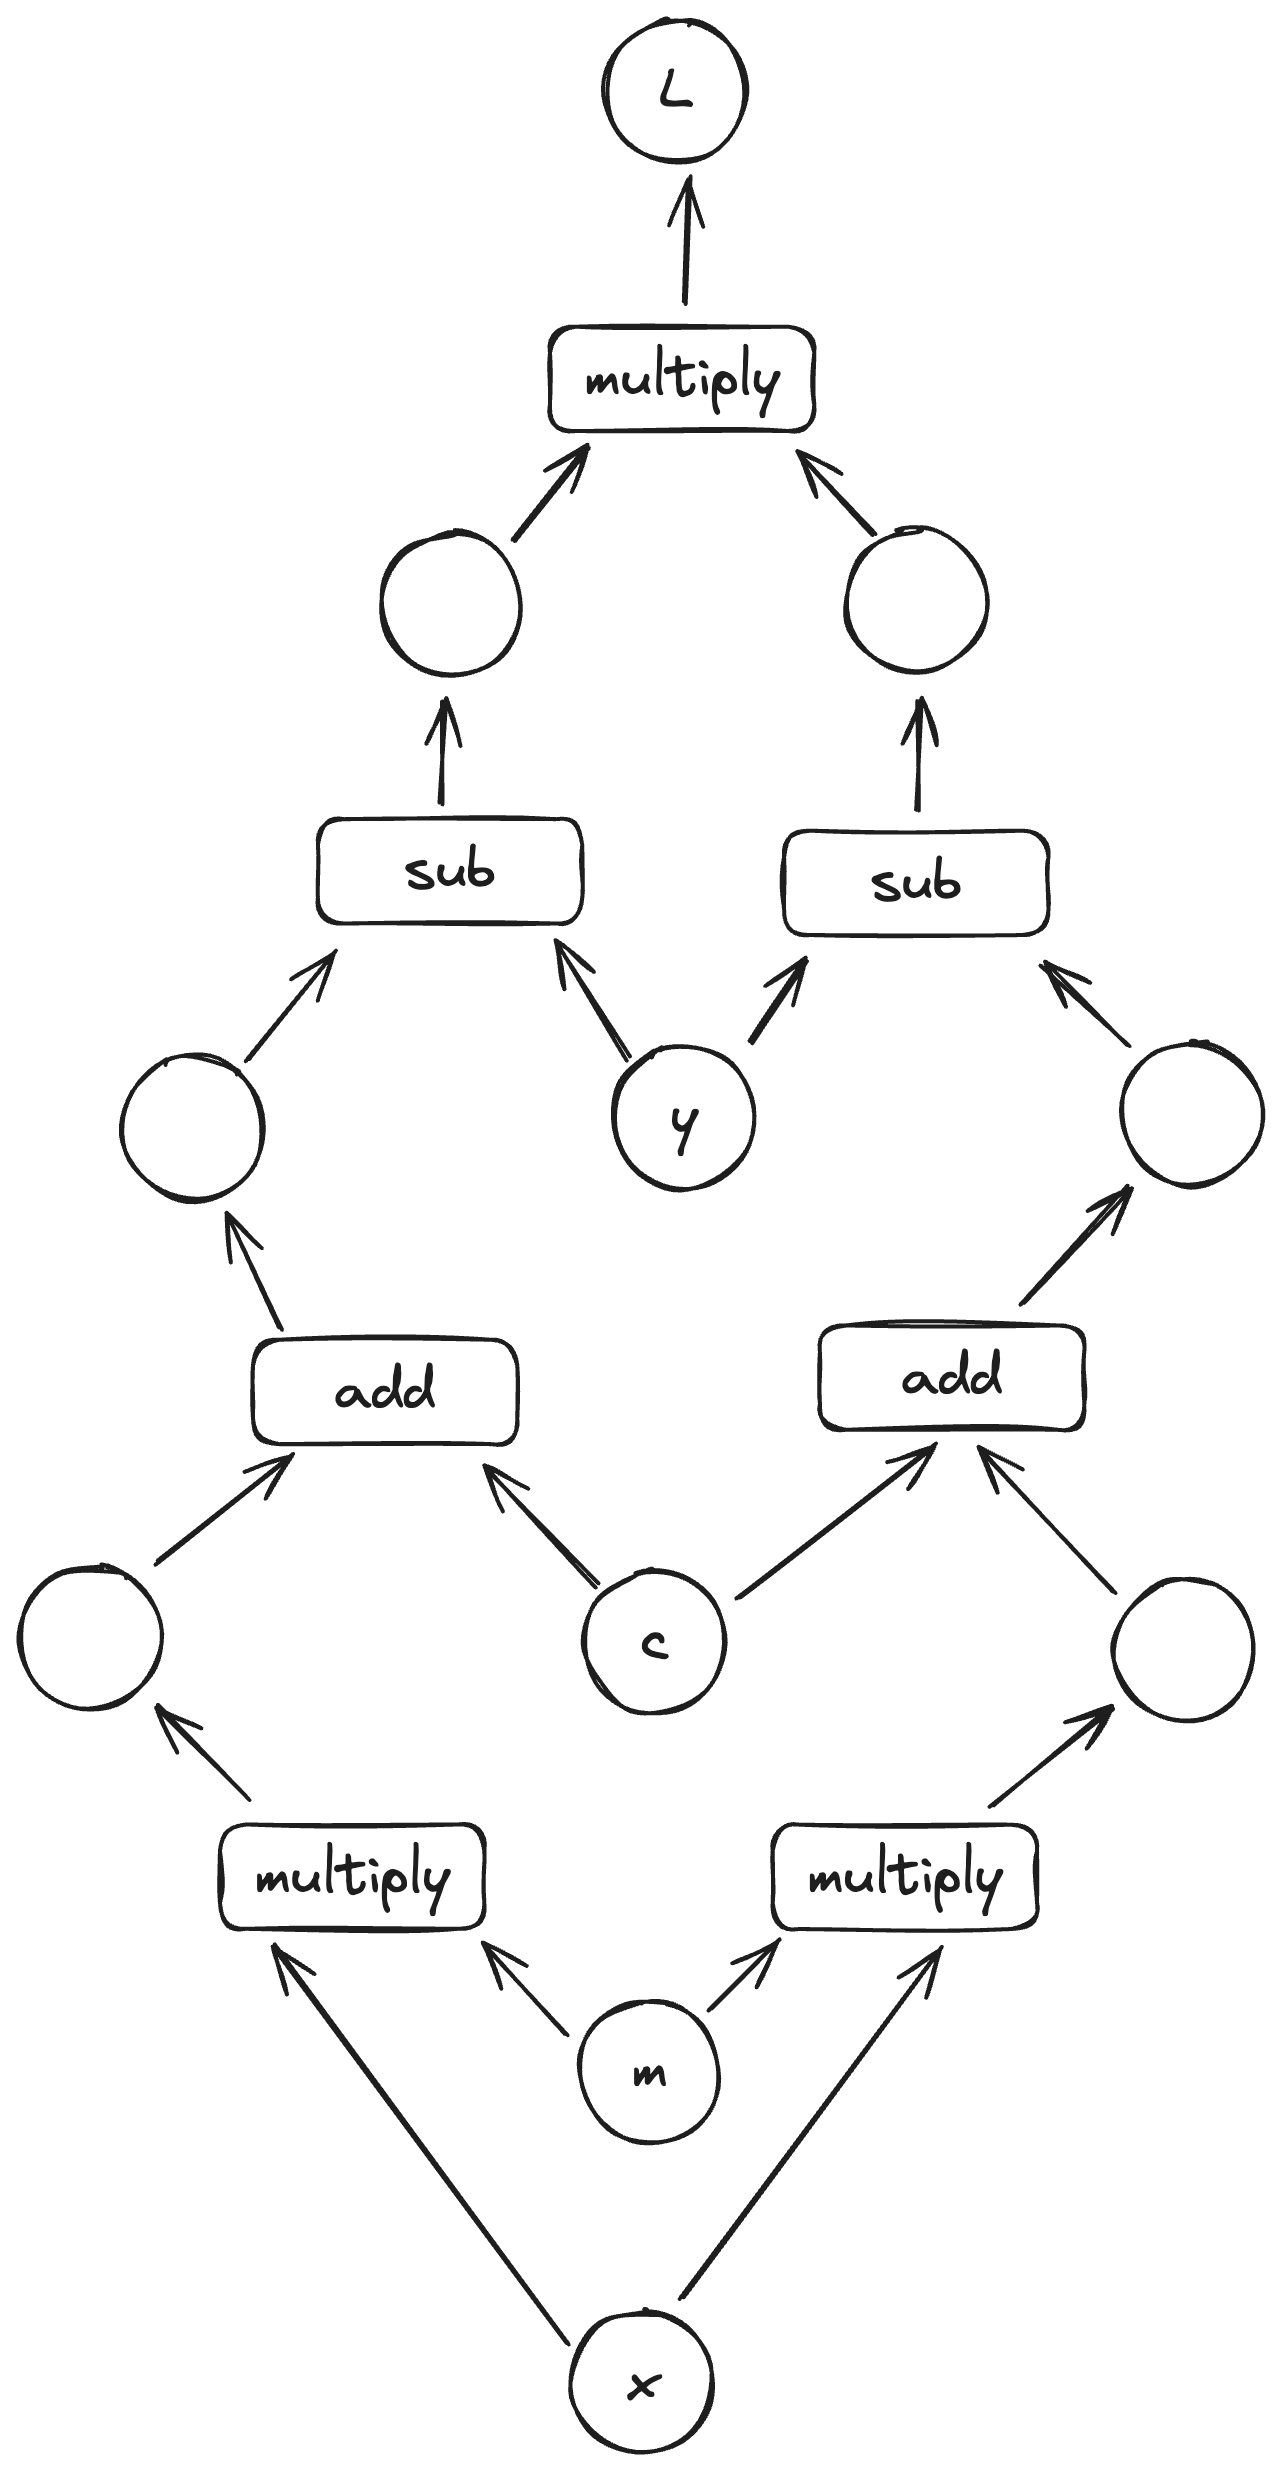